In [ ]:
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [ ]:
cinic_tar_path = './CINIC-10.tar.gz'

In [ ]:
dataset_tar = tarfile.open(cinic_tar_path)
dataset_tar.extractall('./cinic10root')
dataset_tar.close()

In [ ]:
cinic_root_dir = './cinic10root'
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]

In [ ]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cinic_mean,std=cinic_std)])

In [ ]:
train_data = ImageFolder(cinic_root_dir + '/train', transform=tf)
valid_data = ImageFolder(cinic_root_dir + '/valid', transform=tf)
test_data = ImageFolder(cinic_root_dir + '/test', transform=tf)

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

Text(0.5, 0.98, 'CINIC-10 dataset')

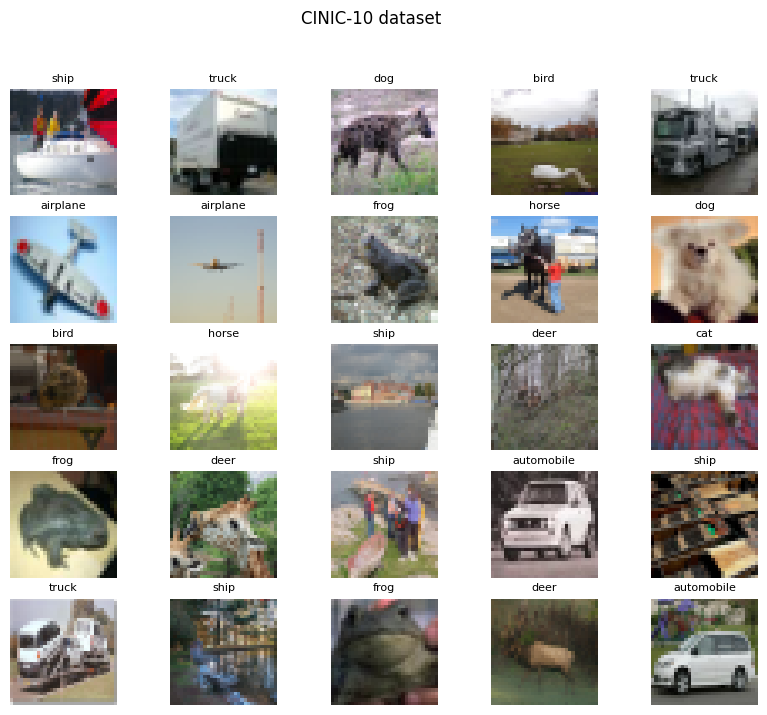

In [ ]:
from random import sample

examples = sample(test_data.imgs, 25)

fig = plt.figure(figsize=(10, 8))
n_rows = 5
n_cols = 5
for index in range(1, n_rows * n_cols + 1):
  plt.subplot(n_rows, n_cols, index)
  plt.axis('off')
  plt.imshow(test_data.loader(examples[index - 1][0]))
  title = f'{test_data.classes[examples[index - 1][1]]}'
  plt.title(title, fontsize=8)
plt.suptitle('CINIC-10 dataset')

In [ ]:
def train_step(model, train_loader, loss_fn, optimizer, device):
  model.train()
  running_loss = 0
  num_correct_pred = 0

  for X, y_true in train_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat = model(X)

    loss = loss_fn(y_hat, y_true)

    pred_labels = torch.argmax(y_hat, 1)
    num_correct_pred += (pred_labels == y_true).sum()

    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_accuracy = num_correct_pred / len(train_loader.dataset)
  return model, optimizer, epoch_loss, epoch_accuracy

In [ ]:
def valid_step(model, valid_loader, loss_fn, device):
  model.eval()
  running_loss = 0
  num_correct_pred = 0

  for X, y_true in valid_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat = model(X)

    loss = loss_fn(y_hat, y_true)

    pred_labels = torch.argmax(y_hat, 1)
    num_correct_pred += (pred_labels == y_true).sum()

    running_loss += loss.item() * X.size(0)
  
  epoch_loss = running_loss / len(valid_loader.dataset)
  epoch_accuracy = num_correct_pred / len(valid_loader.dataset)
  return model, epoch_loss, epoch_accuracy

In [ ]:
def training_loop(model, train_loader, valid_loader, loss_fn, optimizer, n_epochs, scheduler, device):

  train_losses = []
  valid_losses = []

  best_accuracy = 0

  for epoch in tqdm(range(n_epochs), desc='Epoch'):
    model, optimizer, train_loss, train_accuracy = train_step(model, train_loader, loss_fn, optimizer, device)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, valid_loss, valid_accuracy = valid_step(model, test_loader, loss_fn, device)
      valid_losses.append(valid_loss)

    print(f'Train loss:{train_loss:.4f} Validation loss:{valid_loss:.4f} Train accuracy:{train_accuracy * 100:.2f}% Validation accuracy:{valid_accuracy * 100:.2f}%')

    if valid_accuracy > best_accuracy:
      best_accuracy = valid_accuracy
      torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': valid_loss,
                 }, './checkpt.tar')
    
    scheduler.step()

  return model, optimizer, train_losses, valid_losses

In [ ]:
def test(model, test_loader, loss_fn, device):
  checkpoint = torch.load('./checkpt.tar')
  model.load_state_dict(checkpoint['model_state_dict'])
  model.eval()
  running_loss = 0
  num_correct_pred = 0

  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat = model(X)

    loss = loss_fn(y_hat, y_true)

    pred_labels = torch.argmax(y_hat, 1)
    num_correct_pred += (pred_labels == y_true).sum()

    running_loss += loss.item() * X.size(0)
  
  test_loss = running_loss / len(test_loader.dataset)
  test_accuracy = num_correct_pred / len(test_loader.dataset)
  return model, test_loss, test_accuracy

In [ ]:
'''
  ResNet18 from a popular repository
  url:https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
  Modification:
  * a dropout layer for randomization
'''

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

'''
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
'''

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                           stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = ResNet18().to(device)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
n_epochs = 300
initial_lr = 0.1

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=initial_lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

In [ ]:
!nvidia-smi

Tue May  2 05:02:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |    663MiB / 15360MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model, train_losses, valid_losses = training_loop(model, train_loader, valid_loader, loss_fn, optimizer, n_epochs, scheduler, device)

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:1.8706 Validation loss:1.6660 Train accuracy:31.86% Validation accuracy:39.00%


Epoch:   0%|          | 1/300 [02:52<14:19:36, 172.50s/it]

Train loss:1.4011 Validation loss:1.3148 Train accuracy:48.22% Validation accuracy:51.98%


Epoch:   1%|          | 2/300 [05:31<13:36:43, 164.44s/it]

Train loss:1.1709 Validation loss:1.2358 Train accuracy:57.67% Validation accuracy:56.37%


Epoch:   1%|▏         | 4/300 [10:40<12:57:44, 157.65s/it]

Train loss:1.0567 Validation loss:1.5281 Train accuracy:62.08% Validation accuracy:52.21%
Train loss:0.9930 Validation loss:1.1209 Train accuracy:64.64% Validation accuracy:60.79%


Epoch:   2%|▏         | 6/300 [15:51<12:45:34, 156.24s/it]

Train loss:0.9518 Validation loss:1.0888 Train accuracy:66.05% Validation accuracy:60.57%


Epoch:   2%|▏         | 7/300 [18:25<12:39:36, 155.55s/it]

Train loss:0.9197 Validation loss:1.0684 Train accuracy:67.37% Validation accuracy:62.84%


Epoch:   3%|▎         | 8/300 [20:59<12:35:31, 155.25s/it]

Train loss:0.8898 Validation loss:1.0632 Train accuracy:68.39% Validation accuracy:63.16%


Epoch:   3%|▎         | 9/300 [23:34<12:31:47, 155.01s/it]

Train loss:0.8770 Validation loss:1.0571 Train accuracy:68.84% Validation accuracy:63.09%


Epoch:   3%|▎         | 10/300 [26:08<12:28:10, 154.79s/it]

Train loss:0.8664 Validation loss:1.0677 Train accuracy:69.25% Validation accuracy:62.29%
Train loss:0.8520 Validation loss:0.9901 Train accuracy:69.69% Validation accuracy:65.31%


Epoch:   4%|▍         | 12/300 [31:16<12:21:29, 154.48s/it]

Train loss:0.8455 Validation loss:1.0052 Train accuracy:69.98% Validation accuracy:64.28%


Epoch:   4%|▍         | 13/300 [33:49<12:16:50, 154.04s/it]

Train loss:0.8329 Validation loss:0.9649 Train accuracy:70.36% Validation accuracy:66.36%


Epoch:   5%|▍         | 14/300 [36:24<12:15:24, 154.28s/it]

Train loss:0.8299 Validation loss:1.0210 Train accuracy:70.51% Validation accuracy:64.12%


Epoch:   5%|▌         | 15/300 [39:00<12:14:14, 154.58s/it]

Train loss:0.8278 Validation loss:1.1024 Train accuracy:70.62% Validation accuracy:63.33%


Epoch:   5%|▌         | 16/300 [41:32<12:08:42, 153.95s/it]

Train loss:0.8224 Validation loss:1.0509 Train accuracy:70.84% Validation accuracy:63.42%


Epoch:   6%|▌         | 17/300 [44:07<12:07:28, 154.23s/it]

Train loss:0.8158 Validation loss:1.0949 Train accuracy:71.22% Validation accuracy:62.50%
Train loss:0.8114 Validation loss:0.9187 Train accuracy:71.20% Validation accuracy:68.22%


Epoch:   6%|▋         | 19/300 [49:18<12:06:22, 155.10s/it]

Train loss:0.8062 Validation loss:0.8807 Train accuracy:71.47% Validation accuracy:68.81%


Epoch:   7%|▋         | 20/300 [51:55<12:06:31, 155.69s/it]

Train loss:0.8028 Validation loss:0.9562 Train accuracy:71.65% Validation accuracy:66.62%


Epoch:   7%|▋         | 21/300 [54:31<12:04:10, 155.74s/it]

Train loss:0.7997 Validation loss:0.9168 Train accuracy:71.74% Validation accuracy:68.05%


Epoch:   7%|▋         | 22/300 [57:08<12:02:28, 155.93s/it]

Train loss:0.7946 Validation loss:1.0631 Train accuracy:71.75% Validation accuracy:63.33%


Epoch:   8%|▊         | 23/300 [59:43<11:59:42, 155.89s/it]

Train loss:0.7902 Validation loss:1.0468 Train accuracy:71.96% Validation accuracy:64.55%


Epoch:   8%|▊         | 24/300 [1:02:18<11:55:33, 155.56s/it]

Train loss:0.7960 Validation loss:1.0316 Train accuracy:71.91% Validation accuracy:65.56%


Epoch:   8%|▊         | 25/300 [1:04:53<11:52:44, 155.51s/it]

Train loss:0.7883 Validation loss:0.9803 Train accuracy:72.16% Validation accuracy:65.32%


Epoch:   9%|▊         | 26/300 [1:07:29<11:49:41, 155.41s/it]

Train loss:0.7855 Validation loss:1.1322 Train accuracy:72.24% Validation accuracy:61.58%


Epoch:   9%|▉         | 27/300 [1:10:05<11:48:27, 155.71s/it]

Train loss:0.7870 Validation loss:0.9982 Train accuracy:72.24% Validation accuracy:65.16%


Epoch:   9%|▉         | 28/300 [1:12:41<11:46:08, 155.77s/it]

Train loss:0.7825 Validation loss:0.8710 Train accuracy:72.31% Validation accuracy:68.74%


Epoch:  10%|▉         | 29/300 [1:15:16<11:42:48, 155.60s/it]

Train loss:0.7768 Validation loss:0.9651 Train accuracy:72.51% Validation accuracy:65.76%


Epoch:  10%|█         | 30/300 [1:17:53<11:41:39, 155.92s/it]

Train loss:0.7776 Validation loss:1.1416 Train accuracy:72.38% Validation accuracy:61.85%


In [ ]:
torch.save(model.state_dict(), 'resnet18_cinic.pth')

In [ ]:
model, test_loss, test_accuracy = test(model, test_loader, loss_fn, device)
print(f'Test loss:{test_loss:.4f} Test accuracy:{test_accuracy * 100:.2f}%')

In [ ]:
torch.save(model.state_dict(), 'resnet18_cinic_fin.pth')